# Redes Neuronales Recurrentes y Prophet para Predicción de Series Temporales (Core)

Hecho en Colab

**Descripción:**

En este ejercicio, implementarás una red neuronal recurrente (RNN) utilizando LSTM para predecir valores futuros en una serie temporal. Además, se te pide que explores el uso de la herramienta Prophet, un modelo de predicción de series temporales desarrollado por Facebook, y compares los resultados obtenidos con los de la RNN.

**Objetivo:**

El objetivo es predecir los valores futuros de una serie temporal utilizando redes recurrentes y comparar su rendimiento con Prophet. Este ejercicio te permitirá explorar dos enfoques distintos para la predicción de series temporales.

##Importaciones del Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Para hacer gráficos más bonitos
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler  # Para escalar los datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


##Funciones a utilizar

In [2]:
# Función para encontrar valores atípicos POR el método de los cuartiles y el rango intercuartílico (IQR). chatgpt
def identificar_atipicos_IQR(df, columnas):
    atipicos = pd.DataFrame()  # DataFrame para almacenar filas con valores atípicos

    for columna in columnas:
        # Calcular Q1, Q3 y IQR
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1

        # Definir límites para valores atípicos
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtrar filas que tienen valores atípicos
        filas_atipicas = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

        # Concatenar filas atípicas al DataFrame de atípicos
        atipicos = pd.concat([atipicos, filas_atipicas])

    return atipicos.drop_duplicates()  # Eliminar duplicados
def ver_resumen_nulos(df):
    qna=df.isnull().sum(axis=0)
    qsna=df.shape[0]-qna

    ppna=round(100*(qna/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    resumen_nulos =na.sort_values(by='Na en %',ascending=False)
    return resumen_nulos
def desc(df, columns=None):
    """
    Genera un cuadro de estadísticas descriptivas con el porcentaje de std/mean incluido.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el cálculo. Si es None, se incluyen todas las columnas numéricas.

    Returns:
    pd.DataFrame: DataFrame con estadísticas descriptivas y el porcentaje std/mean.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas numéricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    return df_describe

def desc_ceros(df, columns=None):
    """
    Genera un cuadro de estadísticas descriptivas filtrando columnas con mínimo o máximo igual a cero,
    e incluye el porcentaje de std/mean.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el cálculo. Si es None, se incluyen todas las columnas numéricas.

    Returns:
    pd.DataFrame: DataFrame con estadísticas descriptivas y el porcentaje std/mean para las columnas filtradas.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas numéricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    # Filtrar las columnas donde el mínimo o el máximo sea igual a cero
    df_describe = df_describe[(df_describe['min'] == 0) | (df_describe['max'] == 0)]

    return df_describe
def imprimir_bigotes(serie):
    """
    Calcula e imprime los bigotes de una serie de datos.

    Parameters:
    serie (pd.Series): La serie de datos para la cual se calcularán los bigotes.

    Returns:
    None: Imprime los valores de los bigotes.
    """
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los bigotes
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print(f"Límite inferior (bigote inferior): {limite_inferior}")
    print(f"Límite superior (bigote superior): {limite_superior}")
    # Retornar los valores para poder usarlos en otras funciones
    return limite_inferior, limite_superior
def imprimir_bigotes_por_grupo(df, columna, target):
    """
    Imprime los bigotes de los datos por grupo de una columna específica.

    Parameters:
    df (pd.DataFrame): El DataFrame con los datos.
    columna (str): La columna sobre la que se calcularán los bigotes.
    target (str): La columna que contiene las etiquetas de grupo (por ejemplo, 'Species').

    Returns:
    None: Imprime los bigotes por cada grupo.
    """
    print(f"\nBigotes de {columna} por grupo:")
    for species in df[target].unique():
        print(f"\nEspecie: {species}")
        species_data = df[df[target] == species][columna]
        # Imprimir los bigotes solo una vez
        limite_inferior, limite_superior = imprimir_bigotes(species_data)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
def plot_varianza(prm_pca,varianza_minima=90):
    plt.figure(figsize=(12, 6))

    # 1. Ganancia de varianza explicada por cada componente
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(prm_pca.explained_variance_ratio_) + 1),
            prm_pca.explained_variance_ratio_, color='skyblue')
    plt.title('Ganancia de varianza explicada por cada componente')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Ganancia de Varianza Explicada (%)')
    plt.grid(True)

    # Etiquetas en las barras
    for i, v in enumerate(prm_pca.explained_variance_ratio_):
        plt.text(i + 1, v + 0.01, f'{v*100:.2f}%', ha='center')

    # 2. Varianza acumulada
    explained_variance_cumulative = prm_pca.explained_variance_ratio_.cumsum()
    explained_variance_gain = np.diff(explained_variance_cumulative, prepend=0)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(explained_variance_cumulative) + 1),
             explained_variance_cumulative, marker='o', linestyle='--', color='orange')
    plt.title('Variación Explicada Acumulada')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.axhline(y=varianza_minima, color='r', linestyle='--', label=f'{varianza_minima*100}% Umbral')
    plt.axvline(x=np.argmax(explained_variance_cumulative >= varianza_minima) + 1,
                color='g', linestyle='--', label='Número óptimo de componentes')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Mostrar información en consola
    print("Variación explicada acumulada y ganancia:")
    for i, variance in enumerate(explained_variance_cumulative, 1):
        variance_rounded = round(variance, 4)
        print(f"variance_rounded: {variance_rounded}")
        if variance_rounded < 1:
            print(f"Componente {i}: {variance:.2%} ({explained_variance_gain[i-1]*100:.2f}%)")
        else:
          print(f"Existen mas componentes pero ya no aportan variabilidad significativa o es muy infima.")
          break

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)




# Instrucciones:

## 1. Selección del dataset:
  - Utiliza un dataset de series temporales de Kaggle, como el de «Air Quality Prediction» o cualquier otro relacionado con predicción de demanda, precios de acciones, etc. Puedes elegir el dataset que más se relacione con tus intereses.
  - Enlace sugerido: [Air Quality Prediction](https://www.kaggle.com/competitions/air-quality-prediction)

In [3]:
# Especifica la ruta del archivo
file_path = "/content/train.csv"  # Ajusta el nombre si es diferente
test_path = "/content/test.csv"  # Ajusta el nombre si es diferente
# Cargar el archivo en un DataFrame
#df = pd.read_csv(file_path)
df_test = pd.read_csv(test_path)

df_train = pd.read_csv(file_path)
df = df_train.copy()
# Mostrar las primeras filas
print(df.head())


   No  DEWP  TEMP    PRES cbwd   Iws  Is  Ir  AQI
0   1   -16  -4.0  1020.0   SE  1.79   0   0  129
1   2   -15  -4.0  1020.0   SE  2.68   0   0  148
2   3   -11  -5.0  1021.0   SE  3.57   0   0  159
3   4    -7  -5.0  1022.0   SE  5.36   1   0  181
4   5    -7  -5.0  1022.0   SE  6.25   2   0  138


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.9+ MB


In [5]:
# Datos del diccionario con la estructura solicitada
data = {
    "columna": ["No", "DEWP", "TEMP", "PRES", "cbwd", "Iws", "Is", "Ir", "AQI"],
    "tipo": ["int64", "int64", "float64", "float64", "object", "float64", "int64", "int64", "int64"],
    "Descripcion": [
        "Un número secuencial ",
        "Punto de rocío (DEW Point)",
        "Temperatura registrada",
        "Presión atmosférica",
        "Dirección combinada del viento",
        "Velocidad acumulada del viento",
        "Horas acumuladas de nieve",
        "Horas acumuladas de lluvia",
        "Índice de calidad del aire"
    ],
    "Ejemplo": [0, -10, 25.3, 1015.2, "NE", 2.5, 0, 1, 85]
}

# Crear el DataFrame
df_diccionario = pd.DataFrame(data)

# Mostrar el DataFrame
df_diccionario


,columna,tipo,Descripcion,Ejemplo
0,No,int64,Un número secuencial,0
1,DEWP,int64,Punto de rocío (DEW Point),-10
2,TEMP,float64,Temperatura registrada,25.3
3,PRES,float64,Presión atmosférica,1015.2
4,cbwd,object,Dirección combinada del viento,NE
5,Iws,float64,Velocidad acumulada del viento,2.5
6,Is,int64,Horas acumuladas de nieve,0
7,Ir,int64,Horas acumuladas de lluvia,1
8,AQI,int64,Índice de calidad del aire,85


##2. Preprocesamiento de datos:
  - Realiza una exploración inicial de la serie temporal, incluyendo la visualización de la tendencia y la estacionalidad si es aplicable.
  - Realiza un escalado de los datos, ya que las redes neuronales recurrentes se benefician de que los datos estén en un rango similar.

In [6]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
No,41757,0,0.0
DEWP,41757,0,0.0
TEMP,41757,0,0.0
PRES,41757,0,0.0
cbwd,41757,0,0.0
Iws,41757,0,0.0
Is,41757,0,0.0
Ir,41757,0,0.0
AQI,41757,0,0.0


In [7]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [8]:
# 1. Creamos fechas artificiales
# Como no hay fechas, asumimos que cada fila es una medición por hora
# Empezamos desde el 2020.
df['Fecha'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')

<ipython-input-8-8b0e48063a00>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Fecha'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')


In [9]:
# Primeros registros. Se ve que empieza en el 2020.
df.head()

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI,Fecha
0,1,-16,-4.0,1020.0,SE,1.79,0,0,129,2020-01-01 00:00:00
1,2,-15,-4.0,1020.0,SE,2.68,0,0,148,2020-01-01 01:00:00
2,3,-11,-5.0,1021.0,SE,3.57,0,0,159,2020-01-01 02:00:00
3,4,-7,-5.0,1022.0,SE,5.36,1,0,181,2020-01-01 03:00:00
4,5,-7,-5.0,1022.0,SE,6.25,2,0,138,2020-01-01 04:00:00


In [10]:
# Ultimos registros. Se ve que termina en Octubre 2024. Correcto.
df.tail()

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI,Fecha
41752,41753,-23,-2.0,1034.0,NW,231.97,0,0,8,2024-10-05 16:00:00
41753,41754,-22,-3.0,1034.0,NW,237.78,0,0,10,2024-10-05 17:00:00
41754,41755,-22,-3.0,1034.0,NW,242.70,0,0,10,2024-10-05 18:00:00
41755,41756,-22,-4.0,1034.0,NW,246.72,0,0,8,2024-10-05 19:00:00
41756,41757,-21,-3.0,1034.0,NW,249.85,0,0,12,2024-10-05 20:00:00


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   No      41757 non-null  int64         
 1   DEWP    41757 non-null  int64         
 2   TEMP    41757 non-null  float64       
 3   PRES    41757 non-null  float64       
 4   cbwd    41757 non-null  object        
 5   Iws     41757 non-null  float64       
 6   Is      41757 non-null  int64         
 7   Ir      41757 non-null  int64         
 8   AQI     41757 non-null  int64         
 9   Fecha   41757 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 3.2+ MB


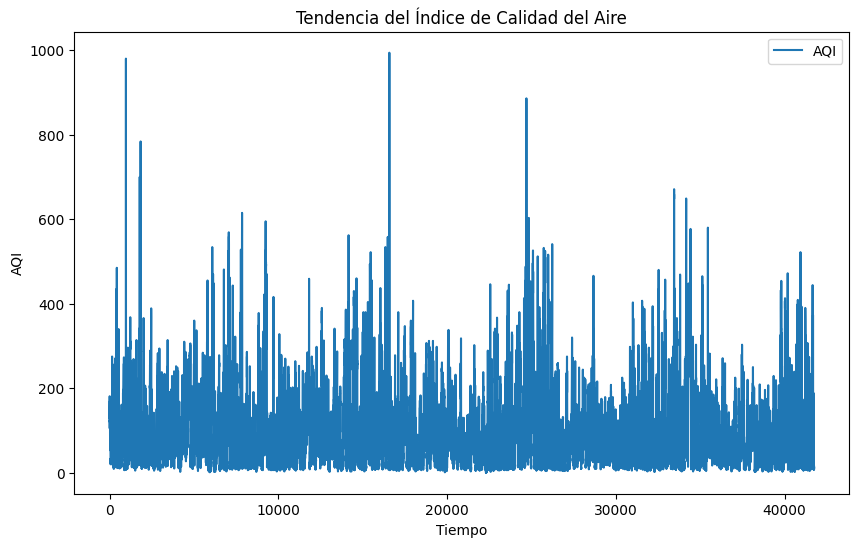

In [12]:
# 2. Visualizar la tendencia del AQI (Índice de Calidad del Aire)
plt.figure(figsize=(10, 6))  # Hacemos un gráfico de tamaño grande
plt.plot(df['AQI'], label='AQI')  # Dibujamos la línea del AQI
plt.title('Tendencia del Índice de Calidad del Aire')  # Título del gráfico
plt.xlabel('Tiempo')  # Etiqueta en el eje X
plt.ylabel('AQI')  # Etiqueta en el eje Y
plt.legend()  # Mostramos la leyenda
plt.show()  # Mostramos el gráfico

In [13]:
# 3 Ponemos la columna 'Fecha' como índice de la tabla
df = df.set_index('Fecha')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2020-01-01 00:00:00 to 2024-10-05 20:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 3.2+ MB


In [15]:
df.head()

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
Fecha,,,,,,,,,
2020-01-01 00:00:00,1,-16,-4.0,1020.0,SE,1.79,0,0,129
2020-01-01 01:00:00,2,-15,-4.0,1020.0,SE,2.68,0,0,148
2020-01-01 02:00:00,3,-11,-5.0,1021.0,SE,3.57,0,0,159
2020-01-01 03:00:00,4,-7,-5.0,1022.0,SE,5.36,1,0,181
2020-01-01 04:00:00,5,-7,-5.0,1022.0,SE,6.25,2,0,138


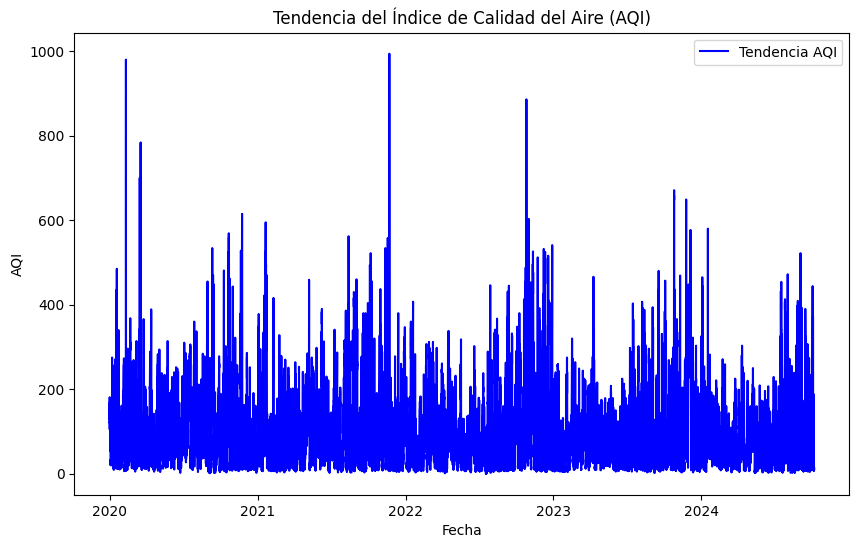

In [16]:
# 3.1 Visualizar la tendencia del AQI (Calidad del Aire) 📈
plt.figure(figsize=(10, 6))  # Hacemos un gráfico grande
plt.plot(df['AQI'], label='Tendencia AQI', color='blue')  # Dibujamos el AQI
plt.title('Tendencia del Índice de Calidad del Aire (AQI)')  # Título del gráfico
plt.xlabel('Fecha')  # Etiqueta del eje X
plt.ylabel('AQI')  # Etiqueta del eje Y
plt.legend()  # Mostramos la leyenda
plt.show()

In [17]:
# 4. Explorar la estacionalidad 📊
# Calculamos el promedio del AQI para cada mes usando las fechas artificiales
df['Mes'] = df.index.month  # Extraemos el mes de cada fecha
aqi_por_mes = df.groupby('Mes')['AQI'].mean()  # Promediamos AQI por mes

<ipython-input-18-da3c61a5b30f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aqi_por_mes.index, y=aqi_por_mes.values, palette='coolwarm')


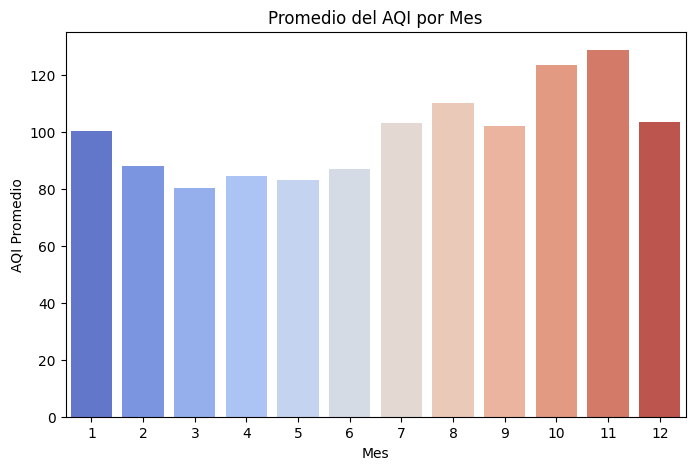

In [18]:
# Hacemos un gráfico para ver si hay patrones que se repiten
plt.figure(figsize=(8, 5))
sns.barplot(x=aqi_por_mes.index, y=aqi_por_mes.values, palette='coolwarm')
plt.title('Promedio del AQI por Mes')  # Título del gráfico
plt.xlabel('Mes')  # Etiqueta en el eje X
plt.ylabel('AQI Promedio')  # Etiqueta en el eje Y
plt.show()

### ¿Qué es la estacionalidad? 🍂☀️❄️  

La **estacionalidad** ocurre cuando los datos muestran **patrones que se repiten** en un periodo de tiempo.  
Por ejemplo:  
- En **verano** hace más calor y en **invierno** hace más frío. 🌞❄️  
- Las ventas de útiles escolares suben siempre en **agosto**. 📚  

---

### ¿Cómo saber si hay estacionalidad? 🕵️‍♀️  
Para ver si hay **patrones repetidos** en los datos:  

1. **Mira los gráficos** 📈:  
   - Si los datos suben y bajan de manera similar cada **mes**, **semana** o **día**, ¡eso es estacionalidad!  
   - Por ejemplo, si la Calidad del Aire (AQI) siempre empeora en invierno y mejora en verano, hay **estacionalidad mensual**.  

2. **Promedia los datos por periodo** 🗓️:  
   - Si haces un gráfico del AQI promediado por mes o semana y ves un **patrón**, entonces sí hay estacionalidad.

---

### ¿Qué pasa si no hay estacionalidad? 🤔  
Si **no ves patrones repetidos** en los gráficos, eso significa que los datos no tienen estacionalidad.  
En ese caso, solo analizamos si la **tendencia** general sube, baja o se queda igual.


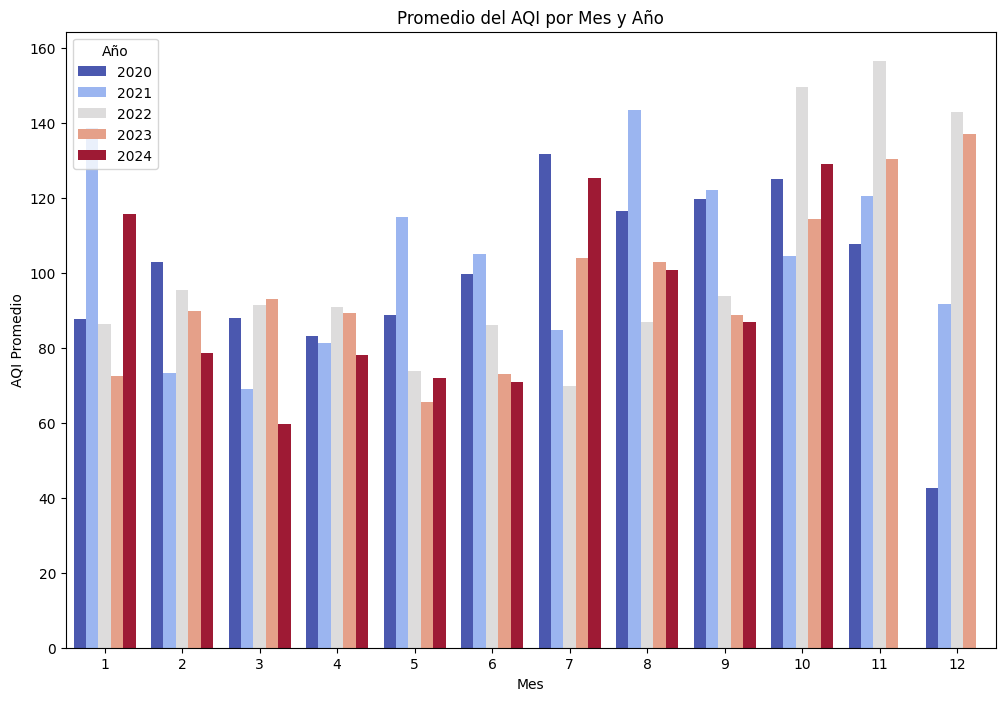

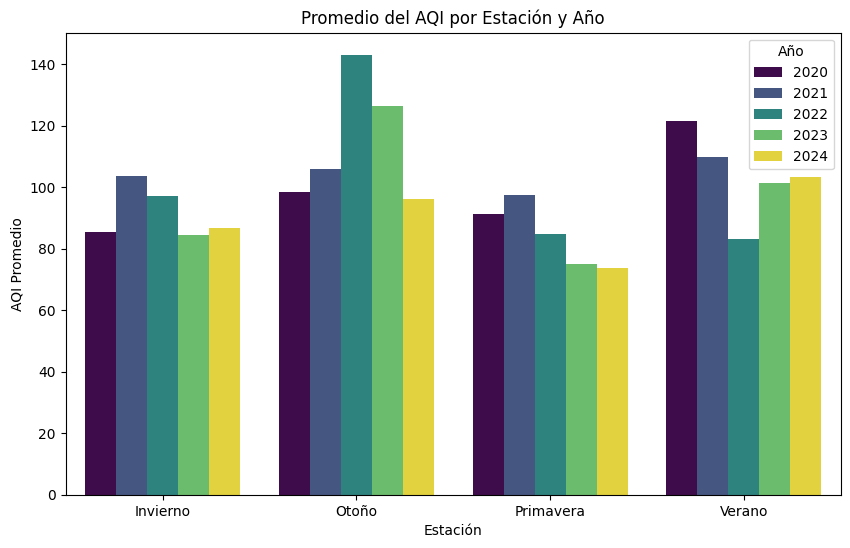

In [19]:
# 2. Extraer año y mes
df['Año'] = df.index.year  # Extraemos el año

# 3. Función para asignar estaciones 🌱☀️🍂❄️
def asignar_estacion(fecha):
    mes = fecha.month
    dia = fecha.day
    if (mes == 3 and dia >= 21) or (mes in [4, 5]) or (mes == 6 and dia < 21):
        return 'Primavera'
    elif (mes == 6 and dia >= 21) or (mes in [7, 8]) or (mes == 9 and dia < 21):
        return 'Verano'
    elif (mes == 9 and dia >= 21) or (mes in [10, 11]) or (mes == 12 and dia < 21):
        return 'Otoño'
    else:
        return 'Invierno'

# 4. Aplicar la función a las fechas
df['Estacion'] = df.index.map(asignar_estacion)

# 5. Calcular el promedio del AQI para cada mes de cada año
promedio_aqi = df.groupby(['Año', 'Mes'])['AQI'].mean().reset_index()

# 6. Crear un gráfico comparativo 📊
plt.figure(figsize=(12, 8))
sns.barplot(x='Mes', y='AQI', hue='Año', data=promedio_aqi, palette='coolwarm')
plt.title('Promedio del AQI por Mes y Año')
plt.xlabel('Mes')
plt.ylabel('AQI Promedio')
plt.legend(title='Año')
plt.show()

# 7. Calcular promedios por estación 🍃
promedio_estacion = df.groupby(['Año', 'Estacion'])['AQI'].mean().reset_index()

# 8. Gráfico de promedios por estación 📉
plt.figure(figsize=(10, 6))
sns.barplot(x='Estacion', y='AQI', hue='Año', data=promedio_estacion, palette='viridis')
plt.title('Promedio del AQI por Estación y Año')
plt.xlabel('Estación')
plt.ylabel('AQI Promedio')
plt.legend(title='Año')
plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2020-01-01 00:00:00 to 2024-10-05 20:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        41757 non-null  int64  
 1   DEWP      41757 non-null  int64  
 2   TEMP      41757 non-null  float64
 3   PRES      41757 non-null  float64
 4   cbwd      41757 non-null  object 
 5   Iws       41757 non-null  float64
 6   Is        41757 non-null  int64  
 7   Ir        41757 non-null  int64  
 8   AQI       41757 non-null  int64  
 9   Mes       41757 non-null  int32  
 10  Año       41757 non-null  int32  
 11  Estacion  41757 non-null  object 
dtypes: float64(3), int32(2), int64(5), object(2)
memory usage: 3.8+ MB


In [21]:
desc(df, columns=['AQI'])

,count,mean,std,min,25%,50%,75%,max,%std/mean
AQI,41757.0,98.613215,92.050387,0.0,29.0,72.0,137.0,994.0,93.34


### ¿Por qué MinMaxScaler para Redes Neuronales (RNN)?

**Redes neuronales y sensibilidad al rango:**

Las redes neuronales funcionan mejor cuando los datos están en un rango pequeño y uniforme, como [0, 1].
La presencia de valores muy grandes o muy pequeños (outliers) puede causar que la red no converja correctamente o tarde mucho más en entrenarse.
Función de activación:

Muchas funciones de activación (como sigmoid o tanh) funcionan dentro de un rango específico:
Sigmoid: Rango [0, 1]
Tanh: Rango [-1, 1]
Al usar MinMaxScaler, aseguras que los datos coincidan mejor con estos rangos, lo que mejora el aprendizaje y la estabilidad.
Datos no necesariamente normales:

Si los datos no siguen una distribución gaussiana (lo cual es común en series temporales), MinMaxScaler mantiene la forma de la distribución intacta y no introduce sesgo.
Aplicaciones en series temporales:

En series temporales, los valores absolutos importan más que la media y la desviación estándar, por lo que MinMaxScaler es más intuitivo.

## Conclusión:
Para Redes Neuronales Recurrentes (RNN), MinMaxScaler es preferido porque:

Escala los datos a un rango adecuado para las funciones de activación.
Es robusto frente a la distribución de los datos.
Mejora la eficiencia del entrenamiento y la convergencia del modelo.

In [22]:
from sklearn.preprocessing import MinMaxScaler

# Paso 1: Conservar el índice original
indice_original = df.index

# Paso 2: Seleccionar solo las columnas numéricas para escalar (excluyendo 'Fecha' si está como columna)
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

# Si 'Fecha' es una columna adicional (y no está como índice), la excluimos explícitamente
columnas_numericas = [col for col in columnas_numericas if col != 'Fecha']

# Crear el MinMaxScaler
scaler = MinMaxScaler()

# Aplicar el escalado solo a las columnas numéricas (exceptuando 'Fecha')
df_escalado = df.copy()
df_escalado[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

# 5. Mostrar el resultado escalado
print("Datos escalados:")
print(df_escalado.head())

# Paso 3: Restaurar el índice original (si es que no lo habías perdido)
df_escalado.index = indice_original

# Verificar el índice
print(df_escalado.index)


Datos escalados:
                           No      DEWP      TEMP      PRES cbwd       Iws  \
Fecha                                                                        
2020-01-01 00:00:00  0.000000  0.352941  0.245902  0.527273   SE  0.002372   
2020-01-01 01:00:00  0.000024  0.367647  0.245902  0.527273   SE  0.003947   
2020-01-01 02:00:00  0.000048  0.426471  0.229508  0.545455   SE  0.005522   
2020-01-01 03:00:00  0.000072  0.485294  0.229508  0.563636   SE  0.008690   
2020-01-01 04:00:00  0.000096  0.485294  0.229508  0.563636   SE  0.010265   

                           Is   Ir       AQI  Mes   Año  Estacion  
Fecha                                                              
2020-01-01 00:00:00  0.000000  0.0  0.129779    1  2020  Invierno  
2020-01-01 01:00:00  0.000000  0.0  0.148893    1  2020  Invierno  
2020-01-01 02:00:00  0.000000  0.0  0.159960    1  2020  Invierno  
2020-01-01 03:00:00  0.037037  0.0  0.182093    1  2020  Invierno  
2020-01-01 04:00:00  0.07407

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2020-01-01 00:00:00 to 2024-10-05 20:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        41757 non-null  int64  
 1   DEWP      41757 non-null  int64  
 2   TEMP      41757 non-null  float64
 3   PRES      41757 non-null  float64
 4   cbwd      41757 non-null  object 
 5   Iws       41757 non-null  float64
 6   Is        41757 non-null  int64  
 7   Ir        41757 non-null  int64  
 8   AQI       41757 non-null  int64  
 9   Mes       41757 non-null  int32  
 10  Año       41757 non-null  int32  
 11  Estacion  41757 non-null  object 
dtypes: float64(3), int32(2), int64(5), object(2)
memory usage: 3.8+ MB


##3. Implementación de RNN con LSTM:
- Implementa una red LSTM para predecir la serie temporal. Utiliza una arquitectura simple con una capa LSTM y una capa densa para predecir el valor futuro de la serie temporal.
- Asegúrate de dividir los datos en conjuntos de entrenamiento y prueba, utilizando las primeras partes de la serie para entrenar el modelo y las últimas partes para probar la precisión de las predicciones.

### Paso 1: Preparar la serie temporal

Queremos predecir la columna 'AQI'. Para hacerlo, extraemos los valores de la columna 'AQI' del DataFrame escalado (df_escalado). Como el índice es la fecha, usaremos el índice como la serie temporal.

In [24]:
# Extraemos la serie temporal (en este caso, 'AQI')
serie_temporal_values = df_escalado['AQI'].values  # Usamos los valores de la columna AQI


### Paso 2: Crear las secuencias para LSTM
Ahora necesitamos crear las secuencias de datos. LSTM requiere que los datos de entrada estén en forma de secuencias temporales, y cada secuencia tendrá un número fijo de valores anteriores (lo que llamamos time_step).

Por ejemplo, si time_step=10, para predecir el valor en el time_step+1, el modelo usará los últimos 10 valores de la serie temporal como entrada.

La función create_dataset toma los valores de 'AQI' y los convierte en secuencias de tiempo.

In [25]:
# Función para crear las secuencias de datos (X, y)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step)])  # Los valores de la serie temporal en el tiempo i hasta i+time_step
        y.append(data[i + time_step])    # El valor siguiente (lo que queremos predecir)
    return np.array(X), np.array(y)

# Usamos un time_step de 10
time_step = 10
X, y = create_dataset(serie_temporal_values, time_step)


### Paso 3: Reshape de los datos
LSTM espera los datos de entrada en un formato específico: muestras, time_steps, características. Esto significa que necesitamos reorganizar X para tener esta forma.

In [26]:
X = X.reshape(X.shape[0], X.shape[1], 1)  # [muestras, time_steps, 1]

En este caso, como estamos usando solo una serie (la columna 'AQI'), tenemos solo una característica (es decir, 1 en la última dimensión).

### Paso 4: Dividir en conjuntos de entrenamiento y prueba
El siguiente paso es dividir los datos en entrenamiento y prueba. En este caso, usaremos los primeros datos para entrenar y los últimos para probar, ya que estamos tratando con datos de series temporales, lo cual requiere preservar el orden temporal.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


### Paso 5: Crear y entrenar el modelo LSTM
Ahora que tenemos los datos listos, podemos construir y entrenar el modelo LSTM.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0347 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_absolute_error: 0.0293 - val_mean_squared_error: 0.0019
Epoch 2/50
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0277 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_absolute_error: 0.0215 - val_mean_squared_error: 0.0011
Epoch 3/50
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0022 - mean_absolute_error: 0.0250 - mean_squared_error: 0.0015 - val_loss: 0.0017 - val_mean_absolute_error: 0.0230 - val_mean_squared_error: 0.0011
Epoch 4/50
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0242 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0012
Epoch 5/50
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0231 - mean_squared_error: 0.0013 - val_loss: 0

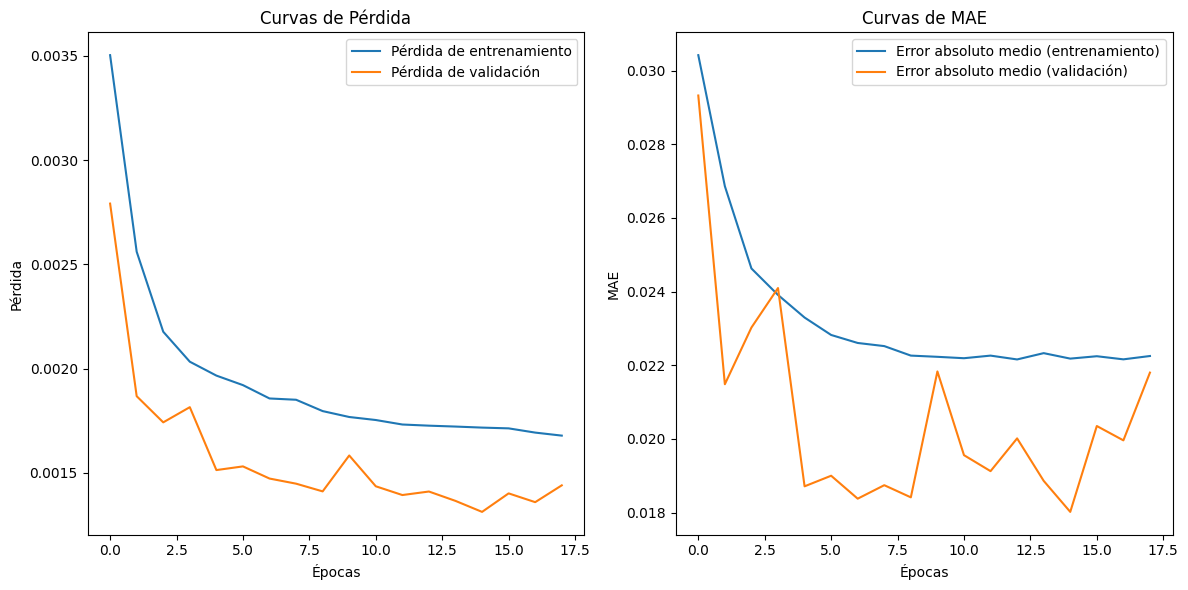

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Crear el modelo LSTM
modelLSTM = Sequential()
modelLSTM.add(LSTM(units=50,
                   return_sequences=False,
                   input_shape=(X_train.shape[1], 1),
                   kernel_regularizer=l2(0.001)))  # Regularización L2
modelLSTM.add(Dropout(0.2))  # Dropout del 20% para evitar sobreajuste
modelLSTM.add(Dense(units=1, kernel_regularizer=l2(0.001)))  # Regularización L2 en la capa densa

# Compilar el modelo con métricas adicionales
modelLSTM.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error', 'mean_squared_error'])

# Early Stopping: Detiene el entrenamiento si no mejora en 3 épocas consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = modelLSTM.fit(X_train, y_train,
                        epochs=50,  # Más épocas, pero el Early Stopping lo detendrá si no mejora
                        batch_size=32,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])  # Añadir Early Stopping

# Graficar las curvas de pérdida y métricas
import matplotlib.pyplot as plt

# Graficar la pérdida (loss)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar una métrica adicional (Mean Absolute Error en este caso)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Error absoluto medio (entrenamiento)')
plt.plot(history.history['val_mean_absolute_error'], label='Error absoluto medio (validación)')
plt.title('Curvas de MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


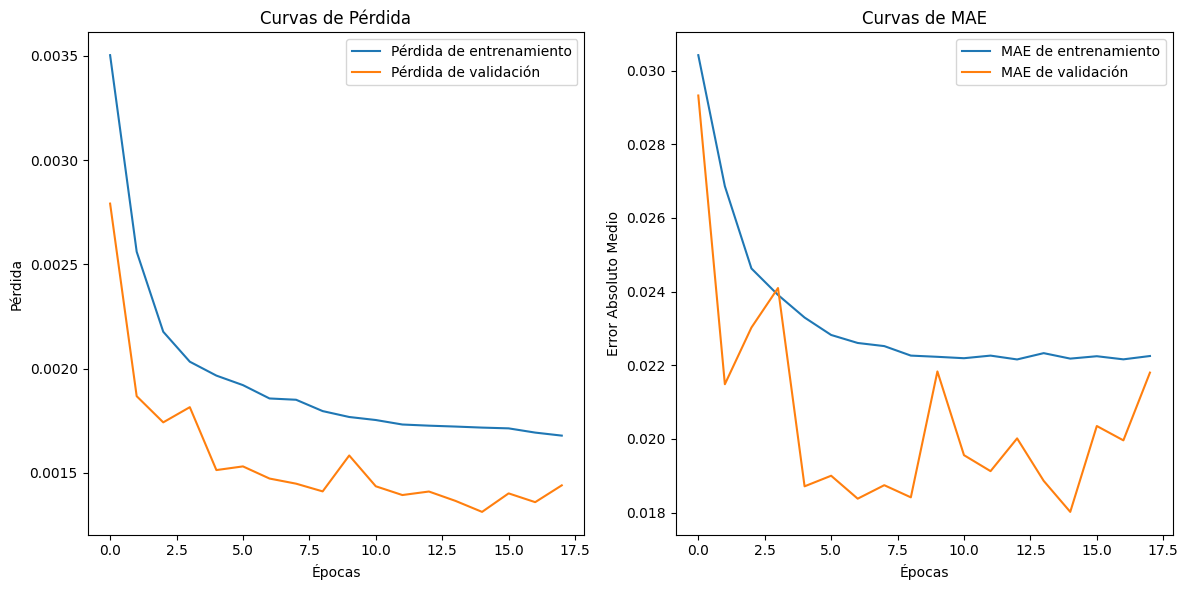

261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


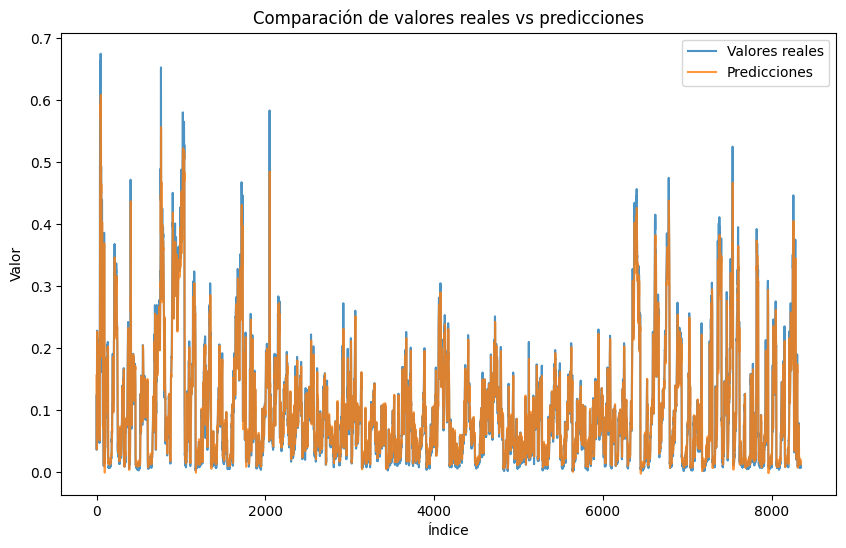

In [29]:
# Graficar las curvas de pérdida y métricas
import matplotlib.pyplot as plt

# Curvas de Pérdida y MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='MAE de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='MAE de validación')
plt.title('Curvas de MAE')
plt.xlabel('Épocas')
plt.ylabel('Error Absoluto Medio')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico de comparación entre predicciones y valores reales
y_pred = modelLSTM.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores reales', alpha=0.8)
plt.plot(y_pred, label='Predicciones', alpha=0.8)
plt.title('Comparación de valores reales vs predicciones')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()


### Paso 6: Hacer predicciones
Finalmente, hacemos las predicciones en el conjunto de prueba:

In [30]:
# Hacer predicciones
predictions = modelLSTM.predict(X_test)


261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Paso 7: Graficar los resultados
Podemos graficar los resultados para ver cómo se comporta la predicción frente a los valores reales:

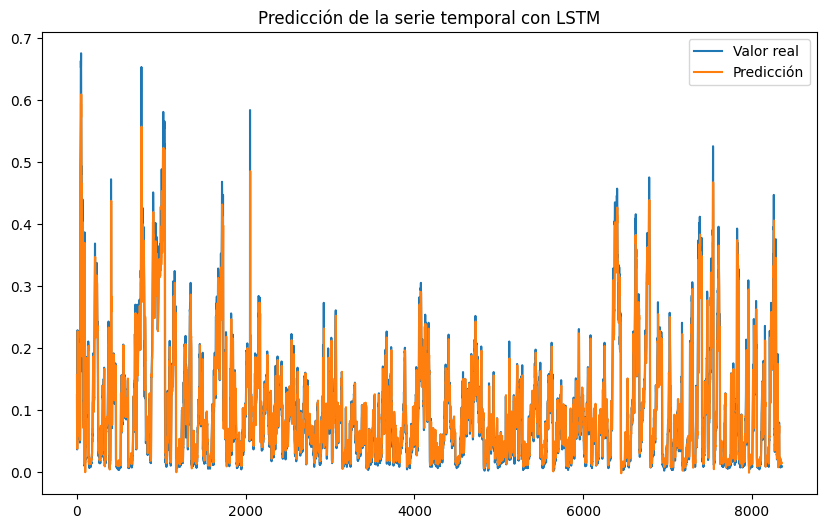

In [31]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Valor real')
plt.plot(predictions, label='Predicción')
plt.title('Predicción de la serie temporal con LSTM')
plt.legend()
plt.show()


Me gusta, aparentemente no tiene overfitting.

In [32]:
desc(df, columns=['AQI'])

,count,mean,std,min,25%,50%,75%,max,%std/mean
AQI,41757.0,98.613215,92.050387,0.0,29.0,72.0,137.0,994.0,93.34


In [33]:
mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')

# Calcular la raíz cuadrada del error cuadrático medio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

mae = mean_absolute_error(y_test, predictions)
print(f'MAE: {mae}')


r2 = r2_score(y_test, predictions)
print(f'R²: {r2}')
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'MAPE: {mape}%')

def smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # Para evitar división por cero
    return 100 * np.mean(diff)

smape_value = smape(y_test, predictions)
print(f'SMAPE: {smape_value}%')


MSE: 0.0009364597076427527
RMSE: 0.03060162916647989
MAE: 0.01801808062622118
R²: 0.8959211799554341
MAPE: 256.1739733625951%
SMAPE: 45.71299845061173%


##4. Uso de Prophet:
  - Instala y utiliza Prophet para predecir la misma serie temporal. Prophet es un modelo que maneja fácilmente tendencias y estacionalidades, por lo que es ideal para comparación con redes recurrentes.
  - Entrena Prophet con los mismos datos que utilizaste para la red LSTM y realiza predicciones en el conjunto de prueba.


In [34]:
#pip install prophet


In [35]:
# Verificar si el índice es de tipo datetime
print(df_escalado.index)


DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2024-10-05 11:00:00', '2024-10-05 12:00:00',
               '2024-10-05 13:00:00', '2024-10-05 14:00:00',
               '2024-10-05 15:00:00', '2024-10-05 16:00:00',
               '2024-10-05 17:00:00', '2024-10-05 18:00:00',
               '2024-10-05 19:00:00', '2024-10-05 20:00:00'],
              dtype='datetime64[ns]', name='Fecha', length=41757, freq=None)


In [36]:
# Convertir el índice a una lista
indice_lista = list(df_escalado.index)
print(indice_lista[:10])  # Muestra los primeros 10 valores del índice como lista



[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-01-01 01:00:00'), Timestamp('2020-01-01 02:00:00'), Timestamp('2020-01-01 03:00:00'), Timestamp('2020-01-01 04:00:00'), Timestamp('2020-01-01 05:00:00'), Timestamp('2020-01-01 06:00:00'), Timestamp('2020-01-01 07:00:00'), Timestamp('2020-01-01 08:00:00'), Timestamp('2020-01-01 09:00:00')]


In [37]:
df_train

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
0,1,-16,-4.0,1020.0,SE,1.79,0,0,129
1,2,-15,-4.0,1020.0,SE,2.68,0,0,148
2,3,-11,-5.0,1021.0,SE,3.57,0,0,159
3,4,-7,-5.0,1022.0,SE,5.36,1,0,181
4,5,-7,-5.0,1022.0,SE,6.25,2,0,138
...,...,...,...,...,...,...,...,...,...
41752,41753,-23,-2.0,1034.0,NW,231.97,0,0,8
41753,41754,-22,-3.0,1034.0,NW,237.78,0,0,10
41754,41755,-22,-3.0,1034.0,NW,242.70,0,0,10
41755,41756,-22,-4.0,1034.0,NW,246.72,0,0,8


In [38]:
df_escalado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2020-01-01 00:00:00 to 2024-10-05 20:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        41757 non-null  float64
 1   DEWP      41757 non-null  float64
 2   TEMP      41757 non-null  float64
 3   PRES      41757 non-null  float64
 4   cbwd      41757 non-null  object 
 5   Iws       41757 non-null  float64
 6   Is        41757 non-null  float64
 7   Ir        41757 non-null  float64
 8   AQI       41757 non-null  float64
 9   Mes       41757 non-null  int32  
 10  Año       41757 non-null  int32  
 11  Estacion  41757 non-null  object 
dtypes: float64(8), int32(2), object(2)
memory usage: 3.8+ MB


In [39]:
df_escalado.head()

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI,Mes,Año,Estacion
Fecha,,,,,,,,,,,,
2020-01-01 00:00:00,0.000000,0.352941,0.245902,0.527273,SE,0.002372,0.000000,0.0,0.129779,1,2020,Invierno
2020-01-01 01:00:00,0.000024,0.367647,0.245902,0.527273,SE,0.003947,0.000000,0.0,0.148893,1,2020,Invierno
2020-01-01 02:00:00,0.000048,0.426471,0.229508,0.545455,SE,0.005522,0.000000,0.0,0.159960,1,2020,Invierno
2020-01-01 03:00:00,0.000072,0.485294,0.229508,0.563636,SE,0.008690,0.037037,0.0,0.182093,1,2020,Invierno
2020-01-01 04:00:00,0.000096,0.485294,0.229508,0.563636,SE,0.010265,0.074074,0.0,0.138833,1,2020,Invierno


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcexgbou7/g02euan3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcexgbou7/x9k4hnk5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24091', 'data', 'file=/tmp/tmpcexgbou7/g02euan3.json', 'init=/tmp/tmpcexgbou7/x9k4hnk5.json', 'output', 'file=/tmp/tmpcexgbou7/prophet_model7id_8ok0/prophet_model-20241227004849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:48:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:49:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


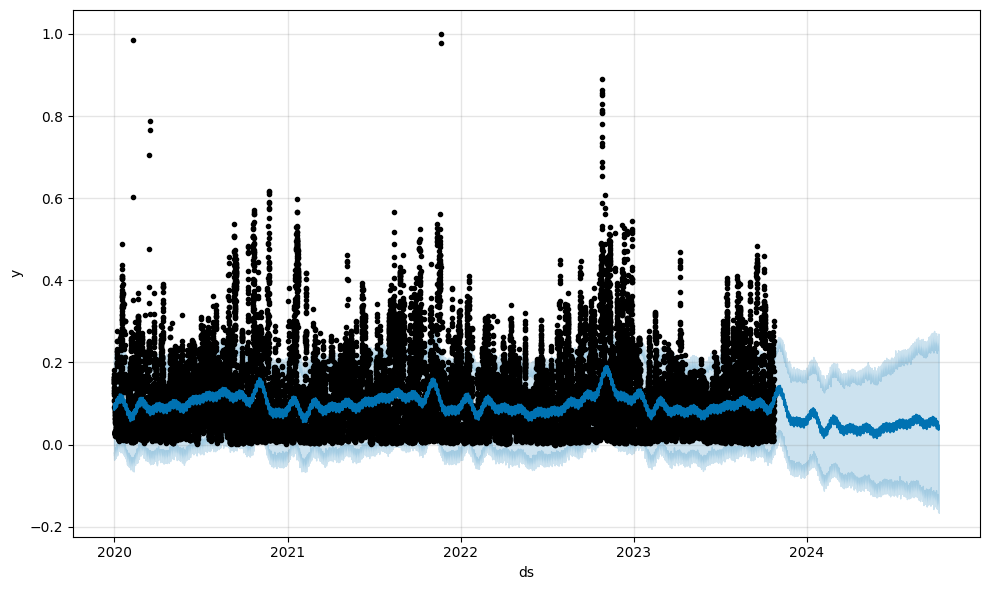

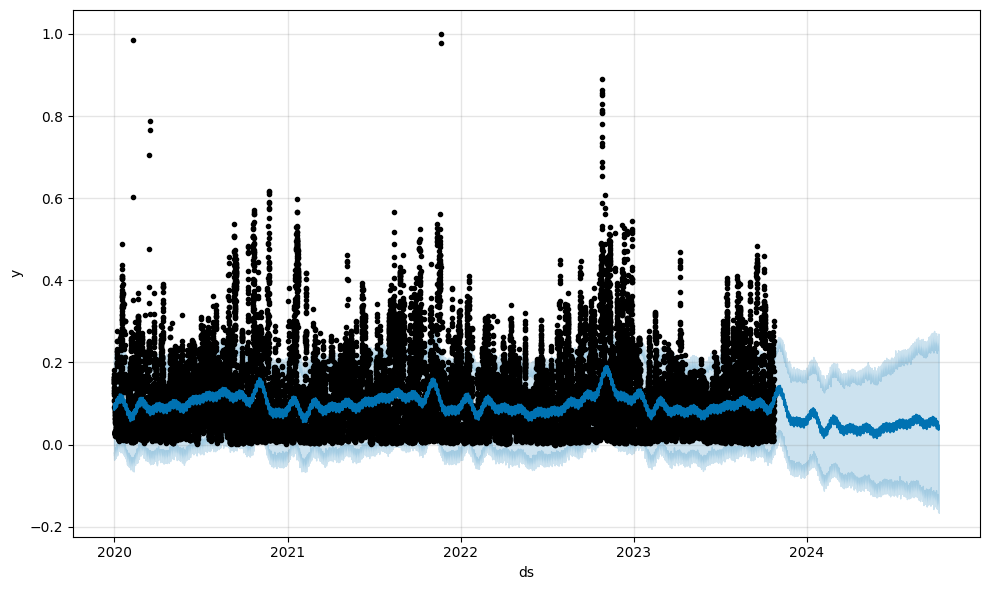

In [40]:
from prophet import Prophet
import pandas as pd

# Preparar los datos para Prophet
# Asegúrate de que 'Fecha' esté en formato datetime y sea el índice
df_prophet = df_escalado.reset_index()[['Fecha', 'AQI']]

# Renombrar las columnas para que Prophet las reconozca
df_prophet = df_prophet.rename(columns={'Fecha': 'ds', 'AQI': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Dividir en entrenamiento y prueba
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(df_train)

# Realizar las predicciones
future = model.make_future_dataframe(periods=len(df_test), freq='h')  # extendemos el DataFrame para predicciones
forecast = model.predict(future)

# Predicciones para el conjunto de prueba
predictions_prophet = forecast['yhat'][-len(df_test):].values

# Visualizar el modelo y las predicciones
model.plot(forecast)


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predicciones para el conjunto de prueba
predictions_prophet = forecast['yhat'][-len(df_test):].values
y_true = df_test['y'].values  # Los valores reales del conjunto de prueba

# Calcular MSE, RMSE, MAE, R2
mse = mean_squared_error(y_true, predictions_prophet)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, predictions_prophet)
r2 = r2_score(y_true, predictions_prophet)

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - predictions_prophet) / y_true)) * 100

# Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
smape = np.mean(2 * np.abs(y_true - predictions_prophet) / (np.abs(y_true) + np.abs(predictions_prophet))) * 100

# Imprimir las métricas
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAPE: {mape:.4f}%')
print(f'SMAPE: {smape:.4f}%')


MSE: 0.0110
RMSE: 0.1047
MAE: 0.0692
R2: -0.2175
MAPE: 131.2588%
SMAPE: 80.8889%


# 5. Comparación de resultados:
  - Compara las predicciones de la red LSTM con las predicciones de Prophet. Utiliza métricas como el RMSE (Root Mean Squared Error) o el MAE (Mean Absolute Error) para medir la precisión de ambos modelos.

| Métrica  | Bajo | Alto |
|----------|------|------|
| **RMSE** | Cerca de 0 (mejor) | Depende de la escala de los datos, pero valores muy altos son malos. |
| **MAE**  | Cerca de 0 (mejor) | Entre 5 a 10 podría ser bueno en un rango de valores de 0 a 200. |
| **MAPE** | < 5% es excelente, < 10% es muy bueno | > 20% indica mala precisión, **valores extremadamente altos pueden indicar problemas de escala**. |
| **SMAPE** | < 10% es excelente, < 20% es muy bueno | > 50% indica un ajuste deficiente, **valores cerca de 50% son aceptables pero se pueden mejorar**. |
| **R²**   | Cercano a 0 (malo) | Cercano a 1 (mejor), > 0.80 es generalmente bueno. |



## Comparación de Métricas: LSTM vs Prophet

| **Métrica**  | **LSTM**                            | **Prophet**                        |
|--------------|-------------------------------------|------------------------------------|
| **MSE**      | 0.000936                            | 0.0110                             |
| **RMSE**     | 0.0306                              | 0.1047                             |
| **MAE**      | 0.0180                              | 0.0692                             |
| **R²**       | 0.8959                              | -0.2175                            |
| **MAPE**     | 256.17%                             | 131.26%                            |
| **SMAPE**    | 45.71%                              | 80.89%                             |

---

### Análisis Comparativo

1. **MSE (Error cuadrático medio):**
   - **LSTM** tiene un valor de **0.000936**, que es muy bajo en comparación con **Prophet** (**0.0110**). Esto indica que el modelo LSTM tiene un error más pequeño en términos de las diferencias al cuadrado entre los valores predichos y los reales.
   - **LSTM es más preciso** en este aspecto, mostrando una mejor capacidad para minimizar los errores grandes.

2. **RMSE (Raíz del error cuadrático medio):**
   - **LSTM** tiene un **RMSE** de **0.0306**, mientras que **Prophet** tiene un **RMSE** mucho mayor de **0.1047**.
   - **LSTM tiene un RMSE mucho más bajo**, lo que indica que sus predicciones son, en promedio, mucho más cercanas a los valores reales que las de Prophet.

3. **MAE (Error absoluto medio):**
   - **LSTM** tiene un **MAE** de **0.0180**, mientras que **Prophet** tiene un **MAE** de **0.0692**.
   - Al igual que en las métricas anteriores, **LSTM tiene un MAE mucho más bajo**, lo que indica que las predicciones de LSTM son más exactas y presentan menos error absoluto en comparación con Prophet.

4. **R² (Coeficiente de determinación):**
   - **LSTM** tiene un **R²** de **0.8959**, lo que indica que el modelo explica aproximadamente el **90%** de la variabilidad de los datos, lo que es una excelente indicación de que el modelo tiene un buen rendimiento.
   - **Prophet**, en cambio, tiene un **R²** de **-0.2175**, lo que indica que el modelo es **muy pobre** en comparación con la media. En este caso, **Prophet no está capturando bien las relaciones en los datos**.

5. **MAPE (Error absoluto medio porcentual):**
   - **LSTM** tiene un **MAPE** extremadamente alto de **256.17%**, lo que es preocupante ya que generalmente los valores de MAPE deben estar por debajo del 100%. Este valor puede sugerir que el modelo LSTM tiene algunos casos de gran error en comparación con los valores reales, aunque su error en términos absolutos es bajo.
   - **Prophet** tiene un **MAPE** de **131.26%**, lo que es significativamente más bajo que el de LSTM, pero aún así está bastante por encima de lo deseado. Esto muestra que **Prophet tiene un error más relativo** en términos porcentuales que LSTM.

6. **SMAPE (Error porcentual absoluto simétrico):**
   - **LSTM** tiene un **SMAPE** de **45.71%**, lo que es un buen resultado, ya que el SMAPE se considera una métrica robusta para series temporales. Generalmente, valores por debajo del 50% son bastante buenos.
   - **Prophet**, por otro lado, tiene un **SMAPE** de **80.89%**, lo que indica que **Prophet tiene un error porcentual mucho mayor** que LSTM.

---

### Conclusiones

- **LSTM** parece ser el modelo **superior** en términos de precisión y capacidad de ajuste a los datos, ya que tiene menores errores absolutos y cuadráticos, así como un **R² significativamente alto**.
- **Prophet**, aunque más interpretativo y fácil de usar para series temporales, tiene un desempeño más pobre según las métricas de **MSE**, **RMSE**, **MAE**, y **R²**.
- El **MAPE** y **SMAPE** de LSTM son más altos, pero en general, LSTM es un modelo más adecuado para capturar las relaciones subyacentes en los datos, mientras que **Prophet** tiene dificultades para ajustarse bien a los datos.

**Recomendación:** Dado que **LSTM** tiene un mejor desempeño global en comparación con **Prophet** en este caso, podría ser preferible seguir optimizando el modelo LSTM y explorar técnicas adicionales como ajuste de hiperparámetros o uso de más datos.



**En terminos más sencillos**
- **LSTM** es como un estudiante que hace su tarea muy bien. Si miramos lo que predice, casi siempre está cerca de la respuesta correcta. Por ejemplo, el error de **LSTM** es muy pequeño, lo que significa que sus respuestas están muy cerca de las respuestas reales.

- **Prophet** es como un estudiante que tiene más dificultades. Su tarea tiene errores más grandes. Por ejemplo, sus respuestas están más lejos de la correcta. Además, cuando tratamos de ver cuánto puede explicar sobre los datos, **Prophet** no lo hace muy bien, mientras que **LSTM** lo hace casi perfecto.

- En resumen, **LSTM** es un modelo mucho más preciso y hace predicciones mucho mejores que **Prophet**. Aunque **Prophet** no es tan malo, **LSTM** es el que mejor resuelve el problema.

---

### ¿Qué significa todo esto?

- **LSTM** tiene **menos errores** y es **más preciso**, por eso es el modelo que funciona mejor.
- **Prophet** tiene **más errores** y no puede explicar bien los datos, por lo que **LSTM** sería la mejor opción si quieres que las predicciones sean lo más exactas posible.


Entonces en la práctica:

- **LSM tiene mejores adivinanzas** en números exactos.
- **Prophet es mejor para ver las ideas generales** sin exagerar tanto.


#- Visualiza las predicciones de ambos modelos superpuestas a la serie temporal original para ver cuál se ajusta mejor a los datos.

Paso 1: Preparar los datos
Primero, necesitamos asegurarnos de tener las predicciones de ambos modelos en un formato adecuado y alineadas con la serie temporal original.

In [42]:
# Crear un DataFrame para las predicciones de LSTM
predictions_lstm = pd.DataFrame(predictions, columns=['yhat_lstm'])
predictions_lstm['ds'] = df_prophet['ds'].iloc[train_size:].reset_index(drop=True)  # Fechas para el conjunto de prueba



In [43]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      41757 non-null  datetime64[ns]
 1   y       41757 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 652.6 KB


In [44]:
# Extraemos las predicciones de Prophet
forecast = model.predict(future)

# Asegurémonos de que las predicciones estén en el formato correcto
df_prophet['yhat'] = forecast['yhat']


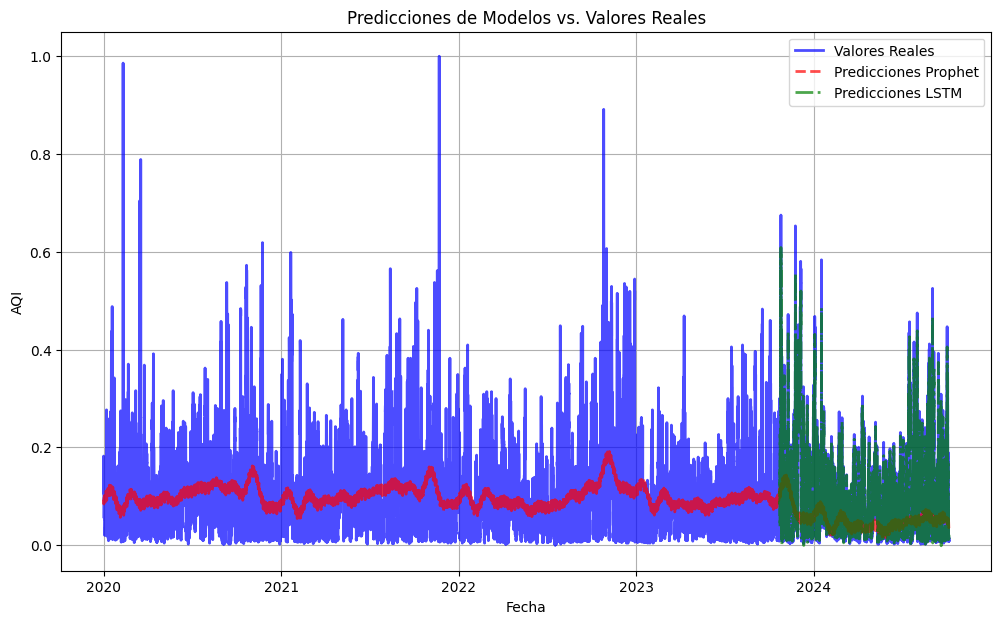

In [45]:
plt.figure(figsize=(12, 7))

# Graficar la serie temporal original
plt.plot(df_prophet['ds'], df_prophet['y'], label='Valores Reales', color='blue', alpha=0.7, linewidth=2)

# Graficar las predicciones de Prophet
plt.plot(df_prophet['ds'], df_prophet['yhat'], label='Predicciones Prophet', color='red', linestyle='--', alpha=0.7, linewidth=2)

# Graficar las predicciones de LSTM
plt.plot(predictions_lstm['ds'], predictions_lstm['yhat_lstm'], label='Predicciones LSTM', color='green', linestyle='-.', alpha=0.7, linewidth=2)

# Títulos y leyenda
plt.title('Predicciones de Modelos vs. Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('AQI')
plt.legend(loc='best')
plt.grid(True)

plt.show()


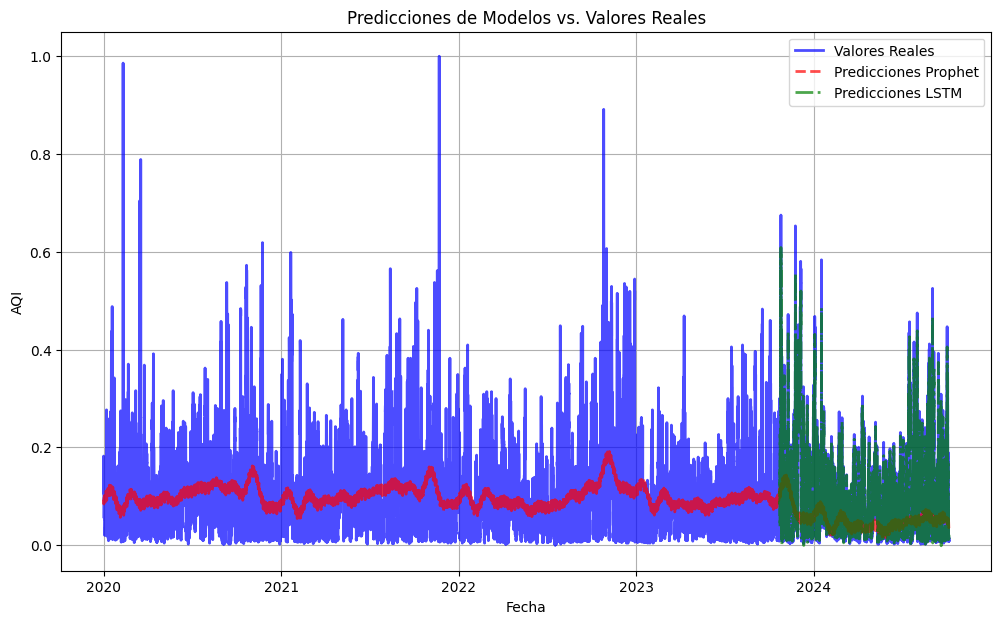

In [46]:
plt.figure(figsize=(12, 7))

# Graficar la serie temporal original
plt.plot(df_prophet['ds'], df_prophet['y'], label='Valores Reales', color='blue', alpha=0.7, linewidth=2)

# Graficar las predicciones de Prophet
plt.plot(df_prophet['ds'], df_prophet['yhat'], label='Predicciones Prophet', color='red', linestyle='--', alpha=0.7, linewidth=2)

# Graficar las predicciones de LSTM
plt.plot(predictions_lstm['ds'], predictions_lstm['yhat_lstm'], label='Predicciones LSTM', color='green', linestyle='-.', alpha=0.7, linewidth=2)

# Títulos y leyenda
plt.title('Predicciones de Modelos vs. Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('AQI')
plt.legend(loc='best')
plt.grid(True)

plt.show()


# 6. Análisis y discusión:
  - Discute cuál de los modelos ofrece mejores resultados en este caso particular. ¿Por qué crees que Prophet o la red LSTM tuvieron un mejor rendimiento?
  - Reflexiona sobre las ventajas y desventajas de cada enfoque para la predicción de series temporales.

### 6. Análisis y Discusión

#### ¿Cuál modelo funciona mejor?

- **LSTM** tiene mejores métricas en comparación con **Prophet**, lo que sugiere que es más preciso en este caso.

#### Comparación de métricas:

| **Métrica**    | **LSTM**                           | **Prophet**                     | **Ponderación LSTM**  | **Ponderación Prophet** |
|----------------|------------------------------------|---------------------------------|-----------------------|-------------------------|
| **MSE**        | 0.00093 (Error bajo +1)            | 0.0110 (Error alto +0)         | +1                    | +0                      |
| **RMSE**       | 0.0306 (Bajo +1)                   | 0.1047 (Alto +0)               | +1                    | +0                      |
| **MAE**        | 0.0180 (Bajo +1)                   | 0.0692 (Alto +0)               | +1                    | +0                      |
| **R²**         | 0.896 (Buen ajuste +1)             | -0.2175 (Poco ajuste +0)       | +1                    | +0                      |
| **MAPE**       | 256.17% (Muy alto +0)             | 131.26% (Alto +1)              | +0                    | +1                      |
| **SMAPE**      | 45.71% (Mejor +1)                  | 80.89% (Peor +0)               | +1                    | +0                      |

#### ¿Por qué LSTM tiene mejor rendimiento?

1. **LSTM** captura patrones más complejos en los datos, lo que le permite hacer predicciones más precisas.
2. **Prophet**, aunque fácil de usar, no maneja bien los patrones complejos y por eso tiene más errores.

#### Ventajas y desventajas:

- **LSTM:**
  - **Ventajas:** Capta patrones complejos, preciso, y funciona mejor con grandes volúmenes de datos.
  - **Desventajas:** Más lento, necesita más datos y recursos computacionales.

- **Prophet:**
  - **Ventajas:** Rápido y fácil de usar, adecuado para datos con patrones simples.
  - **Desventajas:** No captura patrones complejos, por lo tanto, menos preciso.

#### Conclusión:

- **LSTM** es generalmente mejor para datos complejos y más precisos, mientras que **Prophet** es adecuado para patrones más simples, pero menos efectivo en comparación con **LSTM**.
